In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from lazypredict.Supervised import LazyClassifier


In [62]:
df = pd.read_csv("dataset/imdb_movies.csv")
print(df.shape)

(10178, 12)


In [63]:
df.head()

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,Creed III,03/02/2023,73.00,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.00,271616668.00,AU
1,Avatar: The Way of Water,12/15/2022,78.00,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.00,2316794914.00,AU
2,The Super Mario Bros. Movie,04/05/2023,76.00,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.00,724459031.00,AU
3,Mummies,01/05/2023,70.00,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.00,34200000.00,AU
4,Supercell,03/17/2023,61.00,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.00,340941958.60,US


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10178 entries, 0 to 10177
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   names       10178 non-null  object 
 1   date_x      10178 non-null  object 
 2   score       10178 non-null  float64
 3   genre       10093 non-null  object 
 4   overview    10178 non-null  object 
 5   crew        10122 non-null  object 
 6   orig_title  10178 non-null  object 
 7   status      10178 non-null  object 
 8   orig_lang   10178 non-null  object 
 9   budget_x    10178 non-null  float64
 10  revenue     10178 non-null  float64
 11  country     10178 non-null  object 
dtypes: float64(3), object(9)
memory usage: 954.3+ KB


In [65]:
df = df.dropna(subset=['score'])
df['Success'] = (
    (df['revenue'] > df['budget_x']) & (df['score'] >= 70.0)
).astype(int)
print(df['Success'].value_counts())

Success
0    7365
1    2813
Name: count, dtype: int64


In [66]:
df = df.drop(columns=["revenue"])

In [67]:
for col in df.columns:
    if df[col].dtype in ["float64", "int64"]:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna("Unknown")

In [68]:
df = df.drop(columns=["names", "orig_title", "status", "overview"])
df['date_x'] = pd.to_datetime(df['date_x'], errors='coerce')
df['release_year'] = df['date_x'].dt.year
df['release_decade'] = (df['release_year'] // 10) * 10
df['release_month'] = df['date_x'].dt.month

In [69]:
# Season feature
def get_season(month):
    if month in [12,1,2]: return "Winter"
    elif month in [3,4,5]: return "Spring"
    elif month in [6,7,8]: return "Summer"
    elif month in [9,10,11]: return "Fall"
    else: return "Unknown"
df['release_season'] = df['release_month'].apply(get_season)

# Budget buckets
df['budget_bucket'] = pd.cut(
    df['budget_x'],
    bins=[0, 1e6, 2e7, 1e8, np.inf],
    labels=["Low", "Medium", "High", "Blockbuster"]
)

In [70]:
# Simplify genres
df['main_genre'] = df['genre'].str.split(',').str[0]
top_genres = df['main_genre'].value_counts().nlargest(10).index
df['main_genre'] = df['main_genre'].apply(lambda x: x if x in top_genres else "Other")


In [71]:
categorical_cols = ['orig_lang','country','budget_bucket','main_genre','release_season']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [72]:
X = df.drop(columns=["score","Success","crew","date_x","genre"])
y = df["Success"]

print("Final dataset ready")
print("X shape:", X.shape)
print("y distribution:\n", y.value_counts(normalize=True))

Final dataset ready
X shape: (10178, 132)
y distribution:
 Success
0   0.72
1   0.28
Name: proportion, dtype: float64


In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("\nTrain size:", X_train.shape, "Test size:", X_test.shape)

clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None, random_state=42)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)


Train size: (8142, 132) Test size: (2036, 132)


  0%|          | 0/32 [00:00<?, ?it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.7362475442043221, 'Balanced Accuracy': 0.5324177407665992, 'ROC AUC': 0.5324177407665992, 'F1 Score': 0.6490055834155555, 'Time taken': 0.5674467086791992}
{'Model': 'BaggingClassifier', 'Accuracy': 0.6832023575638507, 'Balanced Accuracy': 0.5473315414585089, 'ROC AUC': 0.5473315414585089, 'F1 Score': 0.6579230032254453, 'Time taken': 0.48789238929748535}
{'Model': 'BernoulliNB', 'Accuracy': 0.7234774066797642, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.6073993844624067, 'Time taken': 0.04397082328796387}
{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.7254420432220039, 'Balanced Accuracy': 0.5035523978685613, 'ROC AUC': 0.5035523978685613, 'F1 Score': 0.6119941182746025, 'Time taken': 0.1608724594116211}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.638015717092338, 'Balanced Accuracy': 0.5440842205284222, 'ROC AUC': 0.5440842205284222, 'F1 Score': 0.6366968694174177, 'Time taken': 0.10130882263183594}
{'Model': 'DummyCl

In [74]:
print("LazyClassifier results:")
print(models.head(5))


LazyClassifier results:
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RandomForestClassifier             0.69               0.55     0.55      0.66   
XGBClassifier                      0.73               0.55     0.55      0.67   
ExtraTreesClassifier               0.67               0.55     0.55      0.65   
BaggingClassifier                  0.68               0.55     0.55      0.66   
QuadraticDiscriminantAnalysis      0.73               0.55     0.55      0.67   

                               Time Taken  
Model                                      
RandomForestClassifier               2.51  
XGBClassifier                        0.37  
ExtraTreesClassifier                 1.79  
BaggingClassifier                    0.49  
QuadraticDiscriminantAnalysis        0.04  


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79      1473
           1       0.46      0.47      0.46       563

    accuracy                           0.70      2036
   macro avg       0.63      0.63      0.63      2036
weighted avg       0.70      0.70      0.70      2036

Confusion Matrix:
 [[1161  312]
 [ 300  263]]
ROC AUC: 0.7014683485690927


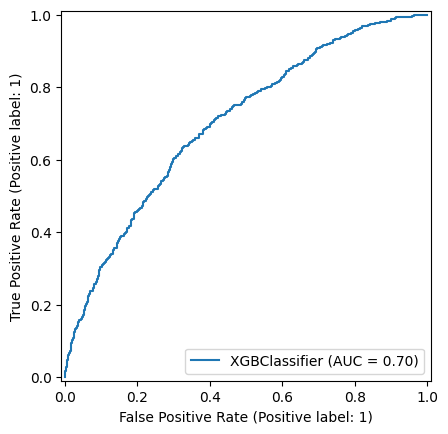

In [86]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=10,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight
)

xgb.fit(X_train, y_train)

# Predict
y_pred = xgb.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))

# ROC Curve
RocCurveDisplay.from_estimator(xgb, X_test, y_test)
plt.show()


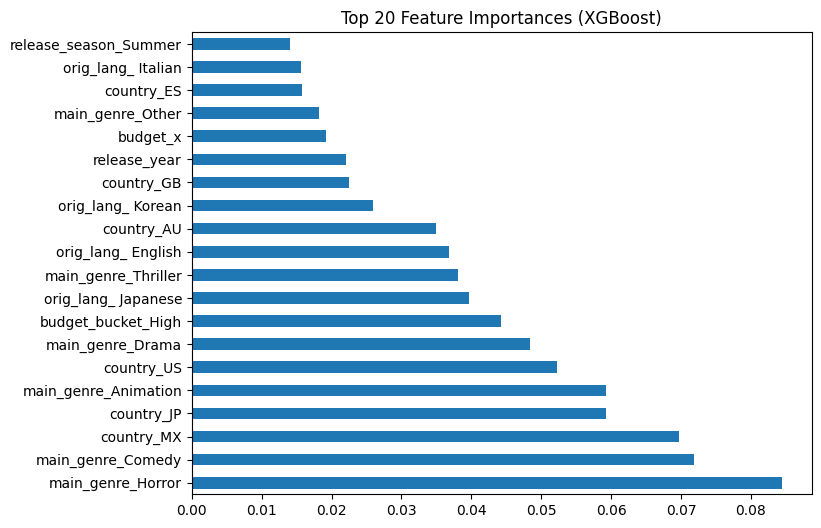

In [79]:
importances = xgb.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)[:20]

feat_imp.plot(kind="barh", figsize=(8,6))
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()
